## Structure of finger representations in M1 (Fixed and Component models)

Example of a fit of fixed and component pcm-models to data from M1. The models and data is taken from [Ejaz et al. (2015)](http://www.diedrichsenlab.org/pubs/Ejaz_NN_2015.pdf). *Hand usage predicts the structure of representations in sensorimotor cortex*, Nature Neuroscience.  

We will fit the following 5 models 

* null: G=np.eye, all finger patterns are equally far away from each other, Note that in many situations the no-information null model, G = np.zeros, maybe more appropriate   
* Muscle: Fixed model with G = covariance of muscle activities 
* Natural: Fixed model with G = covariance of natural movements
* Muscle+nat: Combination model of muscle and natural covariance 
* Noiseceil: Noise ceiling model 

In [1]:
# Import necessary libraries
import PcmPy as pcm
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read in the activity Data (`Data`), condition vector (`cond_vec`), partition vector (`part_vec`), and model matrices for Muscle and Natural stats Models (`M`): 

In [2]:
f = open('data_demo_finger7T.p','rb')
Data,cond_vec,part_vec,modelM = pickle.load(f)
f.close()

Now we are build a list of datasets (one per subject) from the Data and condition vectors 

In [3]:
Y = list()
for i in range(len(Data)):
    obs_des = {'cond_vec': cond_vec[i],
               'part_vec': part_vec[i]}
    Y.append(pcm.dataset.Dataset(Data[i],obs_descriptors = obs_des))

## Inspect the data
Before fitting the models, it is very useful to first visualize the different data sets to see if there are outliers. One powerful way is to estimate a cross-validated estimate of the second moment matrix. This matrix is just another form of representing a cross-validated representational dissimilarity matrix (RDM).

In [4]:
# Estimate and plot the second moment matrices across all data sets
N=len(Y)
G_hat = np.zeros((N,5,5))
for i in range(N):
    G_hat[i,:,:],_ = pcm.util.est_G_crossval(Y[i].measurements,
                            Y[i].obs_descriptors['cond_vec'],
                            Y[i].obs_descriptors['part_vec'],
                            X=pcm.matrix.indicator(Y[i].obs_descriptors['part_vec']))

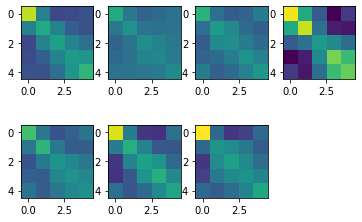

In [5]:
# show all second moment matrices
vmin = G_hat.min()
vmax = G_hat.max()
for i in range(N):
    plt.subplot(2,4,i+1)
    plt.imshow(G_hat[i,:,:],vmin=vmin,vmax=vmax)

Nice - up to a scaling factor (Subject 4 has especially high signal-to-noise) all seven subjects have a very similar structure of the reresentation of fingers in M1.  

## Build the models
Now we are building a list of models, using a list of second moment matrices

In [6]:
# Make an empty list
M = []
# Null model: All fingers are represented independently. 
# For RSA model that would mean that all distances are equivalent
M.append(pcm.model.FixedModel('null',np.eye(5)))
# Muscle model: Structure is given by covariance structure of EMG signals
M.append(pcm.model.FixedModel('muscle',modelM[0]))
# Usage model: Structure is given by covariance structure of EMG signals
M.append(pcm.model.FixedModel('usage',modelM[1]))
# Component model: Linear combination of the muscle and usage model
M.append(pcm.model.ComponentModel('muscle+usage',[modelM[0],modelM[1]]))
# Free noise ceiling model
M.append(pcm.model.FreeModel('ceil',5)) # Noise ceiling model 

Now let's look at two underlying second moment matrices - these are pretty similar

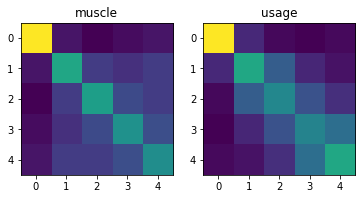

In [7]:
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(M[i+1].G)
    plt.title(M[i+1].name)

## Model fitting
Now let's fit the models to individual data set. There are three ways to do this. We can fit the models

* to each individual participant with it's own parameters $\theta$
* to each all participants together with shared parameters, but with an individual parameter for the signal strength and for group. 
* in a cross-participant crossvalidated fashion. The models are fit to N-1 subjects and evaluated on the Nth subject. 



In [8]:
# Do the individual fits - suppress verbose printout
T_in, theta_in = pcm.inference.fit_model_individ(Y,M,fit_scale = True, verbose = False) 

In [9]:
# Fit the model in to the full group, using a individual scaling parameter for each 
T_gr, theta_gr = pcm.inference.fit_model_group(Y, M, fit_scale=True)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4


In [10]:
# crossvalidated likelihood 
T_cv, theta_cv = pcm.inference.fit_model_group_crossval(Y, M, fit_scale=True)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4


## Inspecting and interpreting the results
The results are returned as a nested data frame with the likelihood, noise and scale parameter for each individuals

In [11]:
T_in

variable    likelihood                                            \
model             null        muscle         usage  muscle+usage   
0        -42231.412711 -41966.470799 -41786.672956 -41786.672927   
1        -34965.171104 -34923.791342 -34915.406608 -34914.959612   
2        -34767.538097 -34679.107626 -34632.643241 -34632.642946   
3        -45697.970627 -45609.052395 -45448.518276 -45448.518254   
4        -31993.363827 -31866.288313 -31806.982719 -31806.982521   
5        -41817.234010 -41632.061473 -41543.438786 -41543.438769   
6        -50336.142592 -50201.799362 -50173.300358 -50173.300306   

variable                   noise                                             \
model             ceil      null    muscle     usage muscle+usage      ceil   
0        -41689.860467  0.875853  0.871286  0.868482     0.868483  0.872297   
1        -34889.042762  1.070401  1.067480  1.069075     1.068119  1.066987   
2        -34571.750931  1.026408  1.021219  1.019122     1.019123  1.023299   
3        -45225.784824  1.480699  1.479592  1.474026     1.474025  1.478701   
4        -31707.184233  0.808482  0.805621  0.805774     0.805774  0.807319   
5        -41439.111953  1.035696  1.031827  1.031649     1.031648  1.034879   
6        -50099.140706  1.479001  1.472401  1.474430     1.474428  1.476145   

variable iterations                                     scale            \
model          null muscle usage muscle+usage  ceil      null    muscle   
0               4.0    4.0   4.0          7.0  30.0  0.109319  0.750145   
1               4.0    4.0   4.0         16.0  21.0  0.045008  0.324407   
2               4.0    4.0   4.0          7.0  32.0  0.059863  0.435483   
3               4.0    4.0   4.0          6.0  18.0  0.173031  1.193770   
4               4.0    4.0   4.0          6.0  32.0  0.073935  0.516338   
5               4.0    4.0   4.0          5.0  19.0  0.116696  0.801114   
6               4.0    4.0   4.0         12.0  29.0  0.101477  0.714043   

variable                                   
model        usage muscle+usage      ceil  
0         0.786771     1.000000  0.996839  
1         0.322917     0.963006  0.998003  
2         0.463987     1.000000  0.992453  
3         1.235628     1.000000  0.998176  
4         0.532421     1.000000  0.999360  
5         0.828773     1.000000  0.999325  
6         0.723969     1.000000  0.981997

The likelihoods are very negative and quite different across participants, which is expected (see documentation). What we need to interpret are the difference is the likelihood relative to a null model. 
We can visualized these using the model_plot

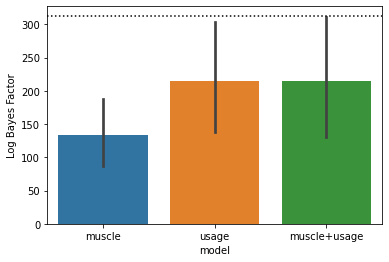

In [12]:
ax = pcm.vis.model_plot(T_in.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil')

The problem with the noise ceiling is that it is individually fit to each subject. It has much more parameters than the models it is competing against, so it is overfitting. To compare models with different numbers of parameters directly, we need to look at our cross-validated group fits. The group fits can be used as an upper noise ceiling.

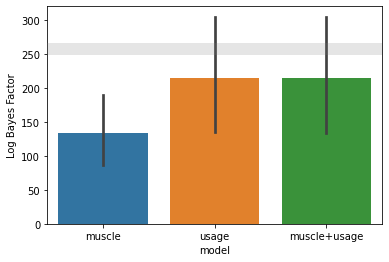

In [13]:
ax = pcm.vis.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil',
                        upper_ceiling = T_gr.likelihood['ceil'])


As you can see, the likelihood for individual, group, and crossvalidated group fits for the fixed models (null, muscle + usage) are all identical, because these models do not have common group parameters - in all cases we are fitting an individual scale and noise parameter. 

## Visualizing the model fit

Finally, it is very useful to visualize the model prediction in comparision to the fitted data. The model parameters are stored in the return argument `theta`. We can pass these to the `Model.predict()` function to get the predicted second moment matrix. 

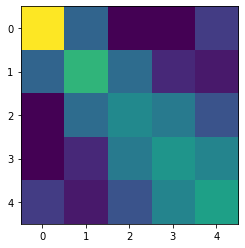

In [15]:
G,_ = M[4].predict(theta_gr[4][:M[4].n_param])
plt.imshow(G)